In [1]:
# Install the missing library
!pip install haversine

# Importing Libraries
import pandas as pd
import numpy as np
import folium
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from keras import regularizers
from keras.layers import BatchNormalization
from haversine import haversine # This line should now work
import matplotlib.pyplot as plt
from folium import plugins # Import the plugins module

In [2]:
# Load the dataset
file_path = r"C:\Users\Aryan\Downloads\bird_tracking.csv"  # Path to the uploaded file
df = pd.read_csv(file_path)

In [3]:
# Display the first few rows
df.head()

,altitude,date_time,device_info_serial,direction,latitude,longitude,speed_2d,bird_name
0,71,2013-08-15 00:18:08+00,851,-150.469753,49.419860,2.120733,0.150000,Eric
1,68,2013-08-15 00:48:07+00,851,-136.151141,49.419880,2.120746,2.438360,Eric
2,68,2013-08-15 01:17:58+00,851,160.797477,49.420310,2.120885,0.596657,Eric
3,73,2013-08-15 01:47:51+00,851,32.769360,49.420359,2.120859,0.310161,Eric
4,69,2013-08-15 02:17:42+00,851,45.191230,49.420331,2.120887,0.193132,Eric


In [4]:
# Convert the 'date_time' column to datetime format
df['date_time'] = pd.to_datetime(df['date_time'])

# Sort the dataset by bird_name and date_time to ensure proper sequencing
df = df.sort_values(by=['bird_name', 'date_time'])

In [5]:
# Feature Engineering: Create separate columns for day, month, year, and hour from the 'date_time' column
df['day'] = df['date_time'].dt.day
df['month'] = df['date_time'].dt.month
df['year'] = df['date_time'].dt.year
df['hour'] = df['date_time'].dt.hour

# Drop any rows with missing values if present
df = df.dropna()

In [6]:
# Select only relevant columns: we need 'latitude', 'longitude', 'altitude', 'speed_2d', 'direction', 'day', 'month', 'year', 'hour', and 'bird_name'
df = df[['bird_name', 'latitude', 'longitude', 'altitude', 'speed_2d', 'direction', 'day', 'month', 'year', 'hour', 'date_time']]

# Display cleaned data
df.head()

,bird_name,latitude,longitude,altitude,speed_2d,direction,day,month,year,hour,date_time
0,Eric,49.419860,2.120733,71,0.150000,-150.469753,15,8,2013,0,2013-08-15 00:18:08+00:00
1,Eric,49.419880,2.120746,68,2.438360,-136.151141,15,8,2013,0,2013-08-15 00:48:07+00:00
2,Eric,49.420310,2.120885,68,0.596657,160.797477,15,8,2013,1,2013-08-15 01:17:58+00:00
3,Eric,49.420359,2.120859,73,0.310161,32.769360,15,8,2013,1,2013-08-15 01:47:51+00:00
4,Eric,49.420331,2.120887,69,0.193132,45.191230,15,8,2013,2,2013-08-15 02:17:42+00:00


In [7]:
# Define the features and labels
features = ['latitude', 'longitude', 'altitude', 'speed_2d', 'direction', 'day', 'month', 'year', 'hour']
scaler = MinMaxScaler()

# Apply scaling only to the features (excluding bird_name and date_time)
df[features] = scaler.fit_transform(df[features])

# Visualize the scaled data
df.head()

,bird_name,latitude,longitude,altitude,speed_2d,direction,day,month,year,hour,date_time
0,Eric,0.946415,0.878275,0.135549,0.002363,0.082023,0.466667,0.636364,0.0,0.000000,2013-08-15 00:18:08+00:00
1,Eric,0.946416,0.878276,0.135172,0.038407,0.121797,0.466667,0.636364,0.0,0.000000,2013-08-15 00:48:07+00:00
2,Eric,0.946427,0.878282,0.135172,0.009398,0.946659,0.466667,0.636364,0.0,0.043478,2013-08-15 01:17:58+00:00
3,Eric,0.946428,0.878281,0.135799,0.004885,0.591024,0.466667,0.636364,0.0,0.043478,2013-08-15 01:47:51+00:00
4,Eric,0.946427,0.878282,0.135298,0.003042,0.625529,0.466667,0.636364,0.0,0.086957,2013-08-15 02:17:42+00:00


In [8]:
# Function to create sequences for LSTM
def create_sequences(data, seq_length):
    sequences = []
    labels = []

    for i in range(len(data) - seq_length):
        sequence = data[i:i + seq_length]
        label = data[i + seq_length, 0:2]  # Predicting only the latitude and longitude
        sequences.append(sequence)
        labels.append(label)

    return np.array(sequences), np.array(labels)

In [9]:
# Set sequence length (e.g., 10 time steps)
seq_length = 10

# Separate the data for each bird and prepare sequences
bird_names = df['bird_name'].unique()
X = []
y = []

for bird in bird_names:
    bird_data = df[df['bird_name'] == bird][features].values
    sequences, labels = create_sequences(bird_data, seq_length)
    X.extend(sequences)
    y.extend(labels)

In [10]:

# Convert lists to numpy arrays
X = np.array(X)
y = np.array(y)

In [11]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# Build LSTM Model
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(seq_length, X_train.shape[2])))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(2))  # Predicting 2 values: latitude and longitude

C:\Users\Aryan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [13]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [14]:
# Train the model for 15 epochs
history = model.fit(X_train, y_train, epochs=15, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/15
769/769 ━━━━━━━━━━━━━━━━━━━━ 25s 27ms/step - loss: 0.5705 - val_loss: 0.0332
Epoch 2/15
769/769 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.0202 - val_loss: 0.0017
Epoch 3/15
769/769 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - loss: 0.0032 - val_loss: 0.0011
Epoch 4/15
769/769 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.0020 - val_loss: 0.0110
Epoch 5/15
769/769 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.0039 - val_loss: 8.2585e-04
Epoch 6/15
769/769 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - loss: 0.0018 - val_loss: 8.8248e-04
Epoch 7/15
769/769 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - loss: 0.0018 - val_loss: 9.8591e-04
Epoch 8/15
769/769 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - loss: 0.0015 - val_loss: 0.0029
Epoch 9/15
769/769 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - loss: 0.0018 - val_loss: 0.0025
Epoch 10/15
769/769 ━━━━━━━━━━━━━━━━━━━━ 22s 29ms/step - loss: 0.0022 - val_loss: 6.6400e-04
Epoch 11/15
769/769 ━━━━━━━━━━━━━━━━━━━━ 23s 30ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 12/15
76

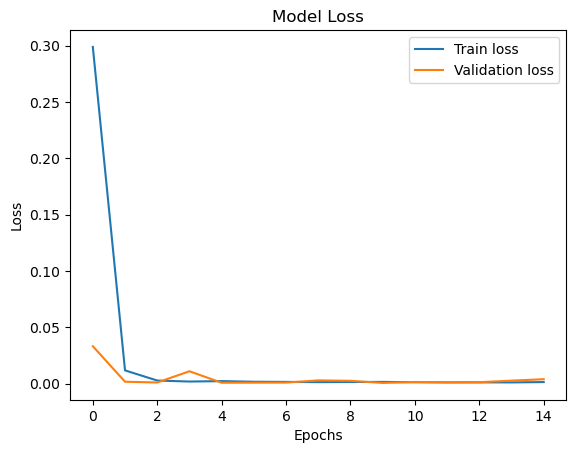

In [15]:
# Plot training & validation loss
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [16]:
# Evaluate the model on test data
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')


385/385 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0040
Test Loss: 0.003950885497033596


In [17]:
# Predict future positions for the test set
y_pred = model.predict(X_test)

# Rescale the predictions back to the original latitude/longitude scale
y_pred_rescaled = scaler.inverse_transform(np.hstack((y_pred, np.zeros((y_pred.shape[0], X_test.shape[2] - 2)))))[:, :2]

# Rescale the true test data back to the original scale for comparison
y_test_rescaled = scaler.inverse_transform(np.hstack((y_test, np.zeros((y_test.shape[0], X_test.shape[2] - 2)))))[:, :2]

385/385 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step


In [18]:
# Predict location for a specific bird and date

# Function to predict for a specific bird and date
def predict_location_on_date(bird_name, target_date):
    # Filter the bird data for the specific bird
    bird_data = df[df['bird_name'] == bird_name]

    # Ensure the target_date is in datetime format
    target_date = pd.to_datetime(target_date)

    # Filter out rows up until the target date
    bird_data = bird_data[bird_data['date_time'] <= target_date]

    # Get the most recent data for prediction
    bird_data_seq = bird_data[features].values[-seq_length:]

    # Scale the data
    bird_data_seq_scaled = scaler.transform(bird_data_seq)

    # Reshape for the LSTM model input
    bird_data_seq_scaled = bird_data_seq_scaled.reshape((1, seq_length, len(features)))

    # Predict future location
    y_bird_pred = model.predict(bird_data_seq_scaled)

    # Rescale the prediction to get the original latitude and longitude
    y_bird_pred_rescaled = scaler.inverse_transform(np.hstack((y_bird_pred, np.zeros((y_bird_pred.shape[0], X_test.shape[2] - 2)))))[:, :2]

    return y_bird_pred_rescaled

In [20]:
# Test with a specific bird and date
bird_name = 'Eric'  # Replace with actual bird name from the dataset
target_date = '2023-05-12 12:00:00'  # Replace with actual target date
target_date = pd.to_datetime(target_date).tz_localize('UTC')

predicted_location = predict_location_on_date(bird_name, target_date)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


C:\Users\Aryan\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [21]:
print(f'Predicted location for {bird_name} on {target_date}: {predicted_location}')

Predicted location for Eric on 2023-05-12 12:00:00+00:00: [[ 22.85835329 -14.49587506]]


In [33]:
import folium

# Assuming you have the predicted latitude and longitude coordinates
predicted_latitude = predicted_location[0,0]  # Replace with your predicted latitude
predicted_longitude = predicted_location[0,1]  # Replace with your predicted longitude
bird_name = 'Eric'  # Replace with your bird name or other label

# Create a map centered around the predicted coordinates
mymap = folium.Map(
    location=[predicted_latitude, predicted_longitude], 
    zoom_start=12, 
    tiles='Stamen Terrain', 
    attr="Map tiles by Stamen Design, under CC BY 3.0. Data by OpenStreetMap, under ODbL."
)

# Add a marker with a label (bird name and coordinates) to the map
folium.Marker(
    location=[predicted_latitude, predicted_longitude],
    popup=f"{bird_name}: {predicted_latitude}, {predicted_longitude}",
    tooltip=f"{bird_name}'s Predicted Location"
).add_to(mymap)

# Switch to ESRI Satellite view (with attribution)
folium.TileLayer(
    tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr='Tiles &copy; Esri &mdash; Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, and the GIS User Community',
    name='Satellite'
).add_to(mymap)

# Adding Layer control to toggle between different map types
folium.LayerControl().add_to(mymap)

# Save the map as an HTML file or display directly in a Jupyter notebook
mymap.save("predicted_location_map.html")

# If you're using a Jupyter notebook, you can display it inline like this:
mymap
